MovieWriter PillowWriter unavailable; using Pillow instead.
MovieWriter PillowWriter unavailable; using Pillow instead.
MovieWriter PillowWriter unavailable; using Pillow instead.


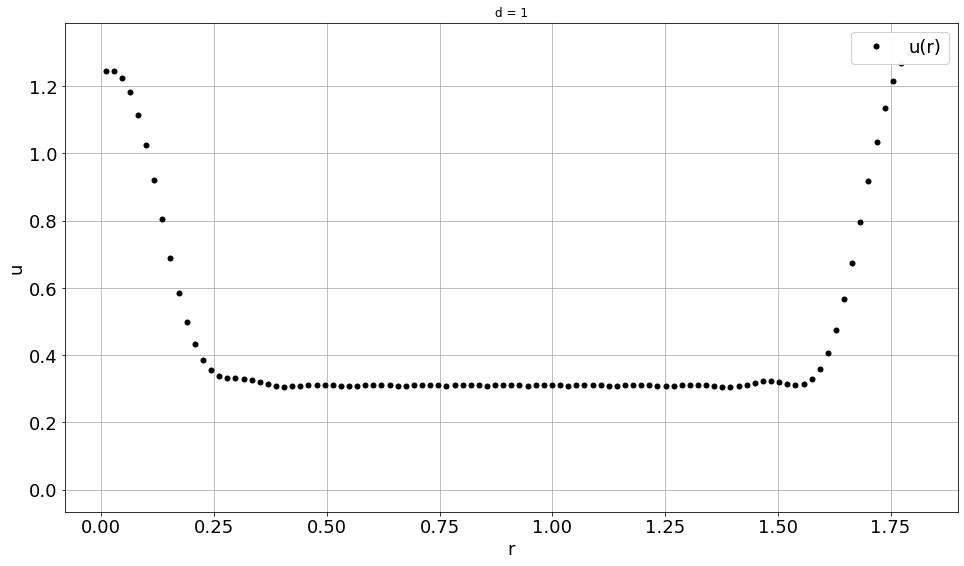

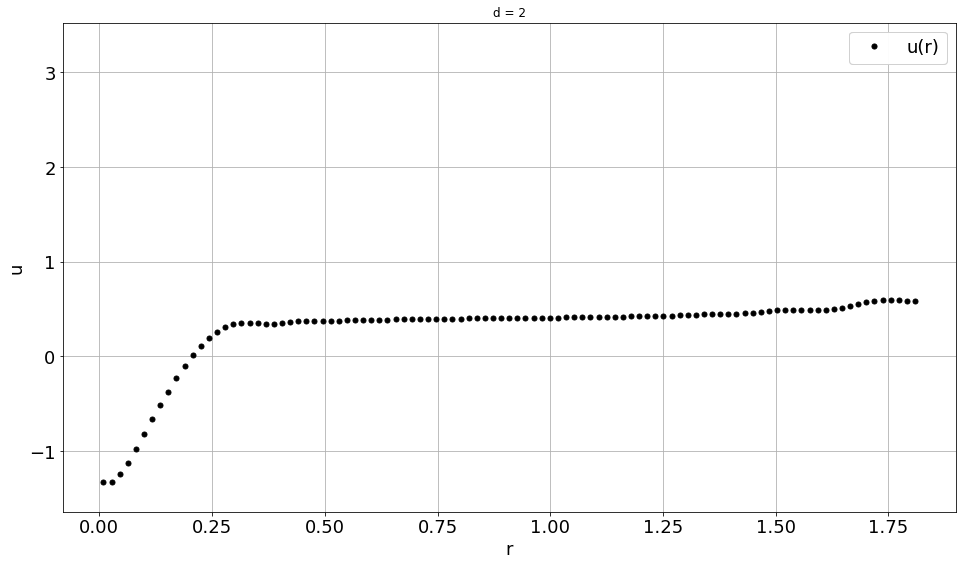

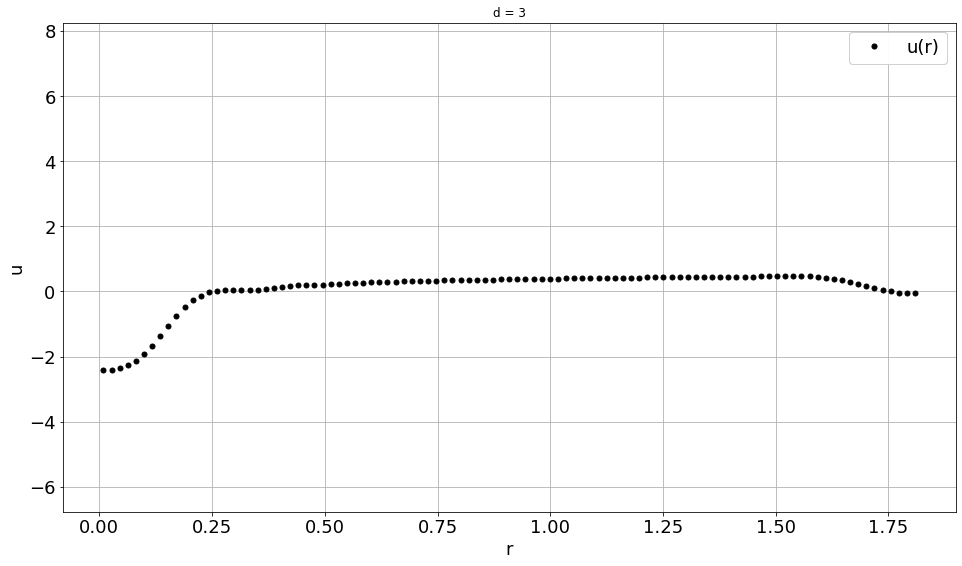

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
import os
from numba import njit

def v0(r, a, b) : 
    if (r > a) and (r < b) : 
        return np.exp((-4*(2*r-(a+b))**2) / ((b-a)**2 - (2*r - (a+b))**2))
    else : 
        return 0
    
def u1(tau, r, v0, v1, v2, v3) : 
    return v0 + tau * v1 + tau**2/2 * v2 + tau**3/6 * v3

def v1(r) : 
    return 0

def v2(r, a, b, c, d) : 
    k = -16 * (2*r - a - b) * (b-a)**2 / ((b-a)**2 - (2*r - a - b)**2)**2
    dkdr =  -16 * (2*(b-a)**2 * ((b-a)**2 - (2*r - a - b)**2)**2 - 8 * (2*r-a-b)**2 * (b-a)**2 * ((b-a)**2 - (2*r-a-b)**2)) / ((b-a)**2 - (2*r-a-b)**2)**4
    
    return c**2 * v0(r, a, b) * ((d-1) * k/r + k**2 + dkdr) 

def v3(r, c, d) : 
    return 0

   
def solver(rmin, rmax, T, c, a, b, d, I, C) : 
    h = (rmax - rmin) / I
    r = np.zeros(I+1)
    for i in range(len(r)) : 
        r[i] = rmin + (i + 0.5) * h
    tau = C*h/c
    
    rr = lambda i: rmin + (i + 0.5)*h
    
    if (C > 1) : 
        print('C must be <= 1')
    
    t = np.linspace(0, T, int(T/tau) + 1)
    
    u = np.zeros((len(t), len(r)))
    
    for i in range(len(r)) : 
        u[0, i] = v0(r[i], a, b)
        u[1, i] = u1(tau, r[i], v0(r[i], a, b), v1(r[i]), v2(r[i], a, b, c, d), v3(r[i], c, d))
        
        
    for n in range(1, len(t) - 1) : 
        for i in range(1, len(r) - 1) :
            u[n+1,i] = 2 * u[n, i] - u[n-1, i] + tau**2*c**2/(r[i]**(d-1)*h)*(rr(i+0.5)**(d-1)* (u[n, i+1] - u[n, i])/h - rr(i-0.5)**(d-1) * (u[n, i] - u[n, i-1])/h)
        u[n+1, 0] = u[n+1, 1]
        u[n+1, -1] = u[n+1, -2]
        
        
    return u, r, t


def draw(u, r, t, d) : 
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
    
    camera = Camera(fig)
    for i in range(len(t)) : 
        ax.plot(r, u[i, :], linestyle = 'None', marker = 'o', color = 'black', markersize = 5)
        camera.snap()
        plt.legend(['u(r)'], loc = 'upper right', fontsize = 18)
        plt.xlabel('r', fontsize = 18)
        plt.ylabel('u', fontsize = 18)
        
    xax = ax.xaxis
    xlocs = xax.get_ticklocs()
    xlabels = xax.get_ticklabels()
    xlines = xax.get_ticklines()

    xax.grid(True)

    for label in xlabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
    
    yax = ax.yaxis
    ylocs = yax.get_ticklocs()
    ylabels = yax.get_ticklabels()
    ylines = yax.get_ticklines()
    yax.grid(True)

    for label in ylabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
        
    plt.title("d = " + str(d))
        
    animation = camera.animate()
    os.chdir(os.getcwd() + "\outData")
    animation.save('d = ' + str(d) + '.gif', writer='PillowWriter', fps = 30)
    os.chdir(os.getcwd().replace("\outData", ""))
    
    
def getSolution(d) : 
    rmin = 0
    rmax = 1.8
    c = 1.5
    a = 0.6
    b = 1.2
    C = 0.5
    T = 3
    I = 100
    
    u, r, t = solver(rmin, rmax, T, c, a, b, d, I, C)
    draw(u, r, t, d)

 
for i in range(3) : 
    getSolution(i+1)
